# Trabaho 1 - Machine Learning 1
#### Autores: 
Roberto Coutinho  
Thais Galho

Agrupe os dados do censo americano de 2005 com o K-means e algum algoritmo hierarquico  
Não considerar a classe do conjunto de dados  
Somente um conjunto de dados  
Dados devem ser pré-processados  
Usar vários números de grupos (ex: 2 a 20)  
Medir a qualidade dos grupos com a silhueta (podem usar outros também)  
Qual é o melhor número de grupos? Qual é o melhor algoritmo? Motivos?  
Entregar via BB o código python ou jupyter e o passo a passo realizado (ex, motivos do pre-processamento etc.) em um zip.

### Imports

In [41]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, calinski_harabaz_score

### Pré-processamento

In [54]:
from sklearn.datasets import load_iris

data = load_iris()

np.random.seed(10)

df = pd.DataFrame(
    np.hstack((
        data['data'], data['target'].reshape(data['target'].shape[0], 1)
    )), columns=data['feature_names'] + ['class']
)



### Execução 

In [115]:
scores = pd.DataFrame(columns=["n_clusters", 
                               "silhuete metric",
                               "calinski metric", 
                               "method",])

num_of_clusters = 5  # Number of clusters

for i in range(num_of_clusters):
    
    i = i + 2 #Does not make sense do one cluster! Start with two.
    
    ##########################################################
    # Run kmeans
    ##########################################################    
    
    kmeans = KMeans(n_clusters=i, 
                    init='k-means++', 
                    n_init=10, 
                    max_iter=300)
    
    kmeans_clust = kmeans.fit(df)
    
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_    
    
    #Calculate the scores
    score_silhuete = silhouette_score(df,labels)
    score_ca = calinski_harabaz_score(df,labels)    
    scores.loc[len(scores)] = [i, score_silhuete, score_ca, 'kmeans']
    
    ##########################################################
    # Run linkage
    ##########################################################
    
    link = linkage(df, 'single')
    
    clusters = fcluster(link, 
                        i, 
                        criterion='maxclust')
    
    #Calculate the scores
    score_silhuete_link = silhouette_score(df,clusters)
    score_ca_link = calinski_harabaz_score(df,clusters)    
    scores.loc[len(scores)] = [i, score_silhuete_link, score_ca_link, 'linkage']
    
    
    # Print results
    print scores.sort_values(['silhuete metric', 'calinski metric'], ascending=[False, False])
    print
    print centroids
    print
    print labels + clusters
    print
    print '--------------------------------'
    print 
    
    
    
    #print link
    #print '--------------------------------'




  n_clusters  silhuete metric  calinski metric   method
1          2         0.682226       493.881371  linkage
0          2         0.679803       497.157354   kmeans

[[6.27373737 2.87575758 4.92525253 1.68181818 1.50505051]
 [5.00784314 3.4        1.49411765 0.26078431 0.01960784]]

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]

--------------------------------

  n_clusters  silhuete metric  calinski metric   method
1          2         0.682226       493.881371  linkage
0          2         0.679803       497.157354   kmeans
2          3         0.581694       583.819609   kmeans
3          3         0.578011       568.547745  linkage

[[5.006      3.418      1.464      0.244      0.        ]
 [6.62244898 2.98367347 5.5734693

In [116]:
print scores.head(10)

  n_clusters  silhuete metric  calinski metric   method
0          2         0.679803       497.157354   kmeans
1          2         0.682226       493.881371  linkage
2          3         0.581694       583.819609   kmeans
3          3         0.578011       568.547745  linkage
4          4         0.538462       519.279276   kmeans
5          4         0.519940       398.328841  linkage
6          5         0.518774       525.685015   kmeans
7          5         0.472410       323.251448  linkage
8          6         0.390888       496.939510   kmeans
9          6         0.446898       295.455704  linkage


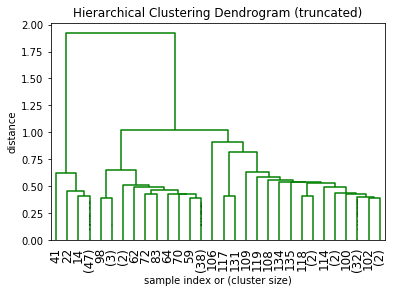

In [117]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

max_d = 5  # max_d as in max_distance

fancy_dendrogram(
    link,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()